# Implmentation of MCDropout using a loaded model

In [1]:
# Import libraries and such
# Utility things:
import os
import sys
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import math
import pickle
import h5py

# Learning things:
import tensorflow as tf
from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Activation, LSTM, LeakyReLU, Dropout, Input, GRU
from keras import backend as backend
from keras import regularizers, metrics
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TerminateOnNaN
import keras.optimizers as kerasOpt
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, auc, mean_squared_error, roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Using TensorFlow backend.


## Helper/other Functions

In [2]:
# Model Metric Function (When loading in pretrained models)
def auc_roc(y_true, y_pred):
    """ AUROC function that was used as a metric in tensorflow/keras in model training
    """
    return tf.py_func(metrics.roc_auc_score, (y_true, y_pred), tf.double)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """ Prints confusion matrixes in a 'pretty' way in the console output
    """
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

def uncertainty_filtering(prediction_df, y_true, threshold):
    """ Helper function to filter and return predictions and true labels based on the std of 
        the output of the MCDropout passes
        
        inputs:
        prediction_df -- a pandas df containing the std of the MC outputs as a column
        y_true -- a numpy array of the true class labels
        threshold -- proportion of predictions to keep ie. 0.9 would retain 90% of the predictions
        
        outputs:
        y_pred_threshold -- numpy array of the thresholded predictions
        y_true_threshold -- numpy array of the thresholded labels
    """
    sorted_pred_df = prediction_df.sort_values('std', ascending=True)
    indicies = list(sorted_pred_df.y_idx.values)
    threshold_indicies = indicies[0:int(len(indicies)*threshold)]
    threshold_indicies.sort()
    y_true_threshold = y_true[threshold_indicies]
    y_pred_threshold = prediction_df.iloc[threshold_indicies]['mean'].values
    
    return y_pred_threshold, y_true_threshold

def bootstrap_auc(y_true, y_pred, ax, t_type='', color='k', nsamples=1000):
     """ Helper function that plots teh AUROC and applies bootstrap as a method to compute and plot 95% CI
        
        inputs:
        y_true -- a numpy array of the true class labels
        y_pred -- a numpy array of the predicted class labels
        ax -- pyplot axes instance to plot the AUROC and CI
        t_type -- assignment of a legend name
        color -- color to plot the curve as
        n_samples -- number of bootstrap samples
        
        outputs:
        none
    """
    if t_type == 'DE':
        legend_name = 'Deep Ensemble '
    elif t_type == 'MC':
        legend_name = 'MCDropout '
    else:
        legend_name = ''
    
    auc_values = []
    tpr_values = []
    for b in range(nsamples):
        idx = np.random.randint(y_true.shape[0], size=y_true.shape[0])
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        fpr, tpr, _ = roc_curve(y_true_bs, y_pred_bs, drop_intermediate=True)
        if b ==0:
            fpr_interp = fpr
        f = interp1d(fpr, tpr)
        tpr_interp = f(fpr_interp)
        
        #auc_score = metrics.auc(fpr, tpr)
        #print(auc_score)
        
        roc_auc = roc_auc_score(y_true_bs, y_pred_bs)
        auc_values.append(roc_auc)
        tpr_values.append(tpr_interp)
    auc_ci = np.percentile(auc_values, (2.5, 97.5))
    auc_mean = np.mean(auc_values)
    tprs_ci = np.percentile(tpr_values, (2.5, 97.5), axis=0)
    tprs_mean = np.mean(tpr_values, axis=0)
    
    ax.fill_between(fpr_interp, tprs_ci[0], tprs_ci[1], color=color, alpha=0.3, zorder=1, label=str(t_type)+'95% CI')
    ax.plot(fpr_interp, tprs_mean, color=color, label= str(t_type)+'AUC: {0:.3f} ({1:.3f}-{2:.3f})'.format(auc_mean, auc_ci[0], auc_ci[1]), linewidth=3, zorder=0)

## Load Data

In [3]:
X = np.load("/mnt/data2/brandon/reprocessed_data_apr1/physionet_data/apr16/normalized/test_X_obs60_lag10.npy")
y = np.load("/mnt/data2/brandon/reprocessed_data_apr1/physionet_data/apr16/normalized/test_y_obs60_lag10.npy")  

## Load Model, enable dropout at inference, and reinitialize model

In [4]:
model_filepath1 = model_filepath1 = '/mnt/data2/brandon/ScientificReports/LSTM_DeepEnsamble/SR_LSTM_base_model_lag10_obs60_1.hdf5'

model = load_model(model_filepath1, custom_objects={'auc_roc':auc_roc})
model_config = model.get_config()

# Enable "training = True" for dropout at runtime
for i in range(0,len(model_config['layers'])):
    if model_config['layers'][i]['class_name'] == 'Dropout':
        model_config['layers'][i]['inbound_nodes'][0][0][-1]['training'] = True
        
# Reinitialize model using the updated configuration and then reload the weights
model_dropout_enabled = Model.from_config(model_config)
model_dropout_enabled.load_weights(model_filepath1,by_name=True)

## Perform n number of passes using the dropout-enabled network and log result

In [5]:
n_passes = 100

# intialize empty array to NaN 
y_pred_array = np.empty((X.shape[0], n_passes))
y_pred_array[:]=np.nan
print(y_pred_array.shape)

# iterate the prediction n-times
for i in range(0,n_passes):
    y_i = model_dropout_enabled.predict(X)
    y_pred_array[:,i] = y_i.flatten()

# Construct a pandas df using the predictions and calculate various stats on the outputs
preds_df = pd.DataFrame(y_pred_array)
preds_df['mean'] = y_pred_array.mean(axis=1)
preds_df['std'] = y_pred_array.std(axis=1)
preds_df['var'] = y_pred_array.var(axis=1)
preds_df['y_idx'] = preds_df.index 

# Take the mean of the outputs as the prediction
y_pred_mean = preds_df['mean'].values

# Force outputs to binary outputs
y_pred_binary = (np.array(y_pred_mean) > 0.5) * 1   

TN, FP, FN, TP = confusion_matrix(y, y_pred_binary).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_mean, pos_label=1)
auc_score = metrics.auc(fpr, tpr)
accuracy = accuracy_score(y_pred=y_pred_binary, y_true=y)
sensitivity_score = TP / (TP + FN)
specificity_score = TN / (TN + FP)

print('acc:',accuracy)
print('auc:',auc_score)
print('sensitivity:',sensitivity_score)
print('specificity:',specificity_score)
print('')
cm = confusion_matrix(y, y_pred_binary)
print_cm(cm,["Non-AHE","AHE"])

(3246, 100)
acc: 0.8108441158348737
auc: 0.8482328532542406
sensitivity: 0.7368421052631579
specificity: 0.814005782203662

            Non-AHE     AHE 
    Non-AHE  2534.0   579.0 
        AHE    35.0    98.0 


## Plot AUROC and CI when thresholding based on variance of predictions

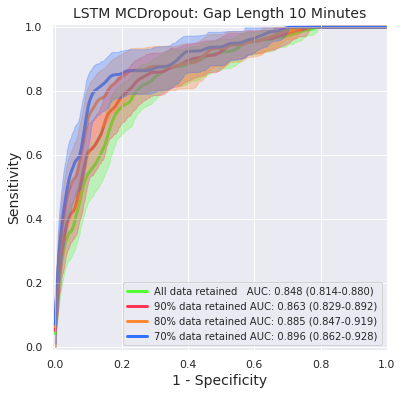

In [7]:
f, ax = plt.subplots(1, 1, figsize=(6,6))

y_pred_thresholded_90, y_true_thresholded_90 = uncertainty_filtering(preds_df, y, 0.9)
y_pred_thresholded_80, y_true_thresholded_80 = uncertainty_filtering(preds_df, y, 0.8)
y_pred_thresholded_70, y_true_thresholded_70 = uncertainty_filtering(preds_df, y, 0.7)

bootstrap_auc(y_pred=preds_df['mean'].values, y_true=y, t_type='All data retained   ', color='#52ff33', ax=ax)
bootstrap_auc(y_pred=y_pred_thresholded_90, y_true=y_true_thresholded_90, t_type='90% data retained ', color='#ff3352', ax=ax)
bootstrap_auc(y_pred=y_pred_thresholded_80, y_true=y_true_thresholded_80, t_type='80% data retained ', color='#ff8833', ax=ax)
bootstrap_auc(y_pred=y_pred_thresholded_70, y_true=y_true_thresholded_70, t_type='70% data retained ', color='#3370ff', ax=ax)

ax.set_title('LSTM MCDropout: Gap Length '+str(10)+' Minutes',fontsize=14)
ax.set_xlim([-0.01, 1.00])
ax.set_ylim([-0.01, 1.01])
ax.set_ylabel('Sensitivity',fontsize=14)
ax.set_xlabel('1 - Specificity',fontsize=14)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:4], labels=labels[0:4], loc=4, fontsize=10)

plt.show()